In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('C:/Users/luizf/Desktop/MINDS/Datasets/HomeC.csv', sep=',')
data = data.drop(labels=['icon','summary','cloudCover', 'House overall [kW]', 'time'], axis=1)
#data = data.loc[0: : 10]
X=data.copy()
X.drop(data.tail(2).index,inplace=True)
X
y=data.copy()
y.loc[max(y.index)+1, :] = None
y=y.shift(-1)
y.dropna(inplace=True)
y

C:\Users\luizf\miniconda3\envs\test\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
1,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
2,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
3,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
4,1.391867,0.003433,0.000283,0.503250,0.063667,0.447033,0.122300,0.006717,0.012433,0.000483,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503904,1.601233,0.003183,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503905,1.599333,0.003233,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503906,1.924267,0.003217,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503907,1.978200,0.003217,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train, X_test = train_test_split(X, test_size=0.25, shuffle=False)
X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
X_train = scaler.fit_transform(X_train.values)
X_val = scaler.fit_transform(X_val.values)
train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=32)

y_train, y_test = train_test_split(y, test_size=0.25, shuffle=False)
y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
y_train = scaler.fit_transform(y_train.values)
y_val = scaler.fit_transform(y_val.values)

In [4]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [5]:
def train_gru(X_train, layer_dim, dropout_prob, epochs, batch_size, learning_rate, step_wdecay, gamma_wdecay, X_val=0):
    train_loader = torch.utils.data.DataLoader(torch.tensor(X_train.astype(np.float32)), batch_size=batch_size, shuffle=False)
    #val_loader = torch.utils.data.DataLoader(torch.tensor(X_val.astype(np.float32)), batch_size=batch_size,shuffle=False)
    if torch.cuda.is_available():
        y_train_t= torch.tensor(y_train.astype(np.float32)).cuda()
        #y_val_t = torch.tensor(y_val.astype(np.float32)).cuda()
    else:
        y_train_t = torch.tensor(y_train.astype(np.float32))
        #y_val_t = torch.tensor(y_val.astype(np.float32))
    torch.manual_seed(1)
    alpha = 0.5
    h=round(X_train.shape[0]/(alpha * (X_train.shape[1]*2)))
    model = GRUModel(X_train.shape[1],h, layer_dim,X_train.shape[1],dropout_prob)
    if torch.cuda.is_available():
        model = model.cuda()
    else:
        model = model.cuda()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    buffer = 10000
    steplr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_wdecay, gamma=gamma_wdecay)

    min_valid_loss=500
    for epoch in range(epochs):
        aux,aux2=0,0
        train_loss=0.0
        model.train()
        for batch, d in enumerate(train_loader):
            if torch.cuda.is_available():
                d =d.cuda()
            optimizer.zero_grad()  #set gradient to 0
            output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
            if torch.cuda.is_available():
                loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
            else:
                loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
            loss.backward()  #differentiate loss with respect to parameters
            optimizer.step() #apply the method step and updates the parameters 
            train_loss += loss.item()
            aux+=d.shape[0]
        steplr.step()

        #valid_loss = 0.0
        #model.eval() 
        #for dv in val_loader:  
        #    if torch.cuda.is_available():
        #        dv =dv.cuda()  
        #    target = model(dv.unsqueeze(1))
        #    if torch.cuda.is_available():
        #        val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        #    else:
        #        val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        #    valid_loss += val_loss.item()
        #    aux2+=dv.shape[0]
        #print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
        #if valid_loss < buffer:
        #    buffer = valid_loss
#
   # print (buffer/len(val_loader))   
    return model

In [6]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

In [7]:
n_windows = 30
w = round(len(X)/n_windows)
buffer =  {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "r2": [],
         "smape":[],
         "nrmse":[],
         "variable":[]
    }
    
col = ["window","rmse","mape","mae","r2","variable"]
result = pd.DataFrame(columns=col)
a={}
for i in range(n_windows):
    dfx=X.iloc[int(w*i):int(w*(i+1)), :]
    dfy=y.iloc[int(w*i):int(w*(i+1)), :]
    from sklearn.preprocessing import MinMaxScaler
    scaler = StandardScaler()
    X_train, X_test = train_test_split(dfx, test_size=0.25, shuffle=False)
    #X_train, X_val = train_test_split(X_train, test_size=0.15, shuffle=False)
    X_train = scaler.fit_transform(X_train.values)
    #X_val = scaler.fit_transform(X_val.values)


    y_train, y_test = train_test_split(dfy, test_size=0.25, shuffle=False)
    #y_train, y_val = train_test_split(y_train, test_size=0.15, shuffle=False)
    y_train = scaler.fit_transform(y_train.values)
    #y_val = scaler.fit_transform(y_val.values)

    model = train_gru(X_train, layer_dim=1, dropout_prob=0, epochs=200, batch_size=64, learning_rate=0.001, step_wdecay=30, gamma_wdecay=0.6)

    model.eval()
    if torch.cuda.is_available():
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
    else:
        test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
    y_norm = scaler.fit_transform(y_test.values)
    #yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
    yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().cpu().numpy())
    #y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]
    
    from pyFTS.benchmarks import Measures
    buffer['rmse']=[Measures.rmse(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mape']=[Measures.mape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['mae']=[mean_absolute_error(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['r2']=[r2_score(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['smape']=[Measures.smape(y_test.values[:,j],yhat[:,j]) for j in range (X.shape[1])]
    buffer['nrmse']=[cal_nrmse(Measures.rmse(y_test.values[:,j],yhat[:,j]),y_test.values[:,j]) for j in range (X.shape[1])]
    buffer['variable']=[j for j in X.columns]
    buffer['window']= w*i

    result = pd.concat([result, pd.DataFrame(buffer)], ignore_index=True)
    #result['rmse'].append([j for j in buffer['rmse']])
    #result['mape'].append(buffer['mape'])
    #result['mae'].append(buffer['mae'])
    #result['r2'].append(buffer['r2'])
    #result['variable'].append([j for j in X.columns])
    #result['window'].append(buffer['window'])
#
#result = np.mean(buffer)
#print (result)


    
    


C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\Measures.py:71: RuntimeWarning: divide by zero encountered in true_divide
  return np.nanmean(np.abs(np.divide(np.subtract(targets, forecasts), targets))) * 100
C:\Users\luizf\miniconda3\envs\test\lib\site-packages\pyFTS\benchmarks\M

In [8]:
result

,window,rmse,mape,mae,r2,variable,smape,nrmse
0,0,0.330392,21.340215,0.204311,0.776885,use [kW],9.978623,0.072955
1,0,0.028417,inf,0.010228,0.862982,gen [kW],35.656414,0.053175
2,0,0.077422,inf,0.027631,0.880789,Dishwasher [kW],91.337895,0.056602
3,0,0.100374,114.252276,0.061654,0.766381,Furnace 1 [kW],28.753064,0.065696
4,0,0.108363,65.952497,0.071908,0.785744,Furnace 2 [kW],21.822713,0.162597
...,...,...,...,...,...,...,...,...
805,487113,0.412404,5.549416,0.275780,0.987447,windSpeed,2.942977,0.028383
806,487113,11.552415,8.691408,5.986267,0.978397,windBearing,2.622938,0.033978
807,487113,0.001217,inf,0.000723,0.985830,precipIntensity,74.706616,0.026052
808,487113,1.283634,4.625639,1.079966,0.893811,dewPoint,2.290749,0.094663


In [9]:
final_measures = {'variable':[], 'rmse': [], 'mae': [], 'mape': [], 'r2': [], 'smape':[], 'nrmse':[], 'rmse_std': [], 'mae_std': [], 'mape_std': [], 'r2_std': [], 'smape_std':[], 'nrmse_std':[]}
m=[]
for i in list(X.columns):
    m=result[result.variable==i].mean()
    st = result[result.variable==i].std()
    final_measures['variable'].append(i)
    final_measures['rmse'].append(m['rmse'])
    final_measures['mae'].append(m['mae'])
    final_measures['mape'].append(m['mape'])
    final_measures['r2'].append(m['r2'])
    final_measures['smape'].append(m['smape'])
    final_measures['nrmse'].append(m['nrmse'])
    final_measures['rmse_std'].append(st['rmse'])
    final_measures['mae_std'].append(st['mae'])
    final_measures['mape_std'].append(st['mape'])
    final_measures['r2_std'].append(st['r2'])
    final_measures['smape_std'].append(st['smape'])
    final_measures['nrmse_std'].append(st['nrmse'])
pd.DataFrame(final_measures)

C:\Users\luizf\AppData\Local\Temp/ipykernel_26092/2831257117.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m=result[result.variable==i].mean()
C:\Users\luizf\AppData\Local\Temp/ipykernel_26092/2831257117.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  st = result[result.variable==i].std()


,variable,rmse,mae,mape,r2,smape,nrmse,rmse_std,mae_std,mape_std,r2_std,smape_std,nrmse_std
0,use [kW],0.437737,0.254199,122.601012,0.513007,19.457082,0.064081,2.867815e-01,1.779335e-01,155.660011,0.747448,12.218781,0.023976
1,gen [kW],0.028579,0.015935,inf,0.931194,39.341298,0.059521,1.106019e-02,7.763987e-03,NaN,0.040519,7.668427,0.020412
2,Dishwasher [kW],0.060248,0.020341,inf,0.808310,93.981054,0.052202,1.578048e-02,7.087102e-03,NaN,0.424468,1.785973,0.037129
3,Furnace 1 [kW],0.063741,0.032985,81.930234,0.735988,26.382191,0.079854,3.151608e-02,2.451249e-02,68.042208,0.131129,13.373809,0.049714
4,Furnace 2 [kW],0.071370,0.048996,48.996938,0.721168,22.726369,0.120620,5.363580e-02,4.363783e-02,46.859191,0.138306,21.651058,0.065635
5,Home office [kW],0.019257,0.009390,14.004471,0.912311,6.728062,0.038206,7.297077e-03,4.624104e-03,6.264198,0.165970,3.094697,0.014478
6,Fridge [kW],0.025481,0.011983,99.325501,0.883797,26.598172,0.044307,4.275560e-03,3.385835e-03,27.988030,0.033097,5.198683,0.015020
7,Wine cellar [kW],0.011483,0.005493,39.565316,0.946700,15.653237,0.060823,7.447198e-03,3.599985e-03,41.486065,0.045071,11.767368,0.034118
8,Garage door [kW],0.011688,0.003412,22.884741,0.164133,9.428535,0.041127,1.103146e-02,3.266539e-03,29.657900,0.178020,7.370238,0.027880
9,Kitchen 12 [kW],0.029157,0.016680,inf,-11.559827,32.084496,0.249094,1.302002e-01,8.351130e-02,NaN,49.577018,29.362227,0.929956


In [ ]:
pd.DataFrame(final_measures).to_csv('gru_kaggle_result.csv')

In [22]:
torch.manual_seed(1)
model = GRUModel(X_train.shape[1],150, 2,X_train.shape[1],0)
if torch.cuda.is_available():
    model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
buffer = 10000

epochs = 20

min_valid_loss=500
for epoch in range(epochs):
    aux,aux2=0,0
    train_loss=0.0
    model.train()
    for batch, d in enumerate(train_loader):
        if torch.cuda.is_available():
            d =d.cuda()
        optimizer.zero_grad()  #set gradient to 0
        output = model(d.reshape(-1, d.shape[1]).unsqueeze(1))  #make a prediction
        if torch.cuda.is_available():
            loss = criterion(output, y_train_t[aux:aux+d.shape[0]])
        else:
            loss = criterion(output, torch.tensor(y_train_t[aux:aux+d.shape[0]].astype(np.float32)))  #calculate the loss
        loss.backward()  #differentiate loss with respect to parameters
        optimizer.step() #apply the method step and updates the parameters 
        train_loss += loss.item()
        aux+=d.shape[0]

    valid_loss = 0.0
    model.eval() 
    for dv in val_loader: 
        if torch.cuda.is_available():
            dv =dv.cuda()   
        target = model(dv.unsqueeze(1))
        if torch.cuda.is_available():
            val_loss = criterion(target, y_val_t[aux2:aux2+dv.shape[0]])
        else:
            val_loss = criterion(target,torch.tensor(y_val_t[aux2:aux2+dv.shape[0]].astype(np.float32)))
        valid_loss += val_loss.item()
        aux2+=dv.shape[0]
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    if valid_loss < buffer:
        buffer = valid_loss

print (buffer/len(val_loader))   
    #if min_valid_loss > valid_loss:
     #   print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})')
      #  min_valid_loss = valid_loss

Epoch 1 		 Training Loss: 0.0341407508532597 		 Validation Loss: 0.05373881666788033
Epoch 2 		 Training Loss: 0.019735000150628047 		 Validation Loss: 0.03987534157931805
Epoch 3 		 Training Loss: 0.01609961776214127 		 Validation Loss: 0.036602970425571715
Epoch 4 		 Training Loss: 0.013242797208666272 		 Validation Loss: 0.031005856820515224
Epoch 5 		 Training Loss: 0.010421584776323762 		 Validation Loss: 0.02784332148730755
Epoch 6 		 Training Loss: 0.008603904424660701 		 Validation Loss: 0.0266323769731181
Epoch 7 		 Training Loss: 0.007447281974098328 		 Validation Loss: 0.026176552660763262
Epoch 8 		 Training Loss: 0.006611950628147437 		 Validation Loss: 0.024893538121666225
Epoch 9 		 Training Loss: 0.005915701909931519 		 Validation Loss: 0.023702464625239374
Epoch 10 		 Training Loss: 0.00532518656744721 		 Validation Loss: 0.02227746554251228
Epoch 11 		 Training Loss: 0.004822278233968327 		 Validation Loss: 0.02055887851331915
Epoch 12 		 Training Loss: 0.004329035039

In [23]:
model.eval()
if torch.cuda.is_available():
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32))).cuda()
else:
    test_norm= torch.tensor(scaler.fit_transform(X_test.values.astype(np.float32)))
y_norm = scaler.fit_transform(y_test.values)
#yhat=scaler.inverse_transform(model(test_norm.unsqueeze(1)).detach().numpy())
yhat=model(test_norm.unsqueeze(1)).detach().cpu().numpy()
#y=scaler.inverse_transform(test_norm.detach().numpy())[:,0]

from pyFTS.benchmarks import Measures
buffer=[Measures.rmse(y_norm[:,i],yhat[:,i]) for i in range (X.shape[1])]
result = np.mean(buffer)
print (result)

0.06911269190394034


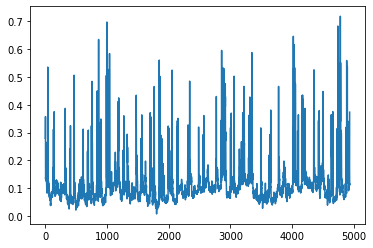

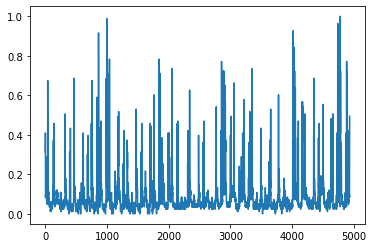

In [20]:
import matplotlib.pyplot as plt
plt.plot(yhat[:,0])
plt.show()
plt.plot (y_norm[:,0])

In [24]:
print (model)

GRUModel(
  (gru): GRU(22, 20, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)
